In [0]:
from pathlib import Path
# import pandas as pd
import os
import numpy as np
# import random
import matplotlib.pyplot as plt
import spacy
# import string
# import re
from spacy.symbols import ORTH
from collections import Counter

%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as tt
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

In [0]:
!mkdir coco
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./coco/ 
!wget http://images.cocodataset.org/zips/train2014.zip -P ./coco/ 
!wget http://images.cocodataset.org/zips/val2014.zip -P ./coco/

--2020-05-25 00:26:09--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19673183 (19M) [application/octet-stream Charset=UTF-8]
Saving to: ‘./coco/captions_train-val2014.zip’

captions_train-val2 100%[===================>]  18.76M  5.14MB/s    in 4.5s    

2020-05-25 00:26:14 (4.17 MB/s) - ‘./coco/captions_train-val2014.zip’ saved [19673183/19673183]

--2020-05-25 00:26:16--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.30.132
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.30.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./coco/train2

In [0]:
from pycocotools.coco import COCO
import json
from PIL import Image
from zipfile import ZipFile

In [0]:
path = Path("coco")
train_ann = path/"annotations/captions_train2014.json"
val_ann = path/"annotations/captions_val2014.json"

In [0]:
from zipfile import ZipFile
# for f in ['captions_train-val2014.zip', 'train2014.zip', 'val2014.zip']:
def extract_zip(filename):
    with ZipFile(path/filename, 'r') as archive:
        archive.extractall(path)

In [0]:
extract_zip('captions_train-val2014.zip')
!rm -rf coco/captions_train-val2014.zip

extract_zip('train2014.zip')
!rm -rf coco/train2014.zip

extract_zip('val2014.zip')
!rm -rf coco/val2014.zip

In [0]:
coco=COCO(train_ann)
coco

loading annotations into memory...
Done (t=2.37s)
creating index...
index created!


In [0]:
train_ids = coco.getImgIds()
train_ids[:10]

[57870, 384029, 222016, 520950, 69675, 547471, 122688, 392136, 398494, 90570]

In [0]:
img_id = train_ids[0]
annIds = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(annIds)
print(train_ids[0])
anns

57870


[{'caption': 'A restaurant has modern wooden tables and chairs.',
  'id': 787980,
  'image_id': 57870},
 {'caption': 'A long restaurant table with rattan rounded back chairs.',
  'id': 789366,
  'image_id': 57870},
 {'caption': 'a long table with a plant on top of it surrounded with wooden chairs ',
  'id': 789888,
  'image_id': 57870},
 {'caption': 'A long table with a flower arrangement in the middle for meetings',
  'id': 791316,
  'image_id': 57870},
 {'caption': 'A table is adorned with wooden chairs with blue accents.',
  'id': 794853,
  'image_id': 57870}]

In [0]:
type(anns), type(anns[0])

(list, dict)

In [0]:
file = coco.loadImgs(img_id)[0]['file_name']
file

'COCO_train2014_000000057870.jpg'

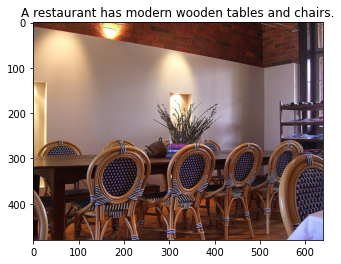

In [0]:
p = path/"train2014"/file
im = Image.open(p)
plt.imshow(im)
plt.title(anns[0]['caption']);

In [0]:
import cv2
img = cv2.imread(str(p))
temp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
temp.shape

(250, 250, 3)

In [0]:
im.size, im.mode

((640, 480), 'RGB')

In [0]:
import gc
gc.collect();

## Data Augmentation

In [0]:
crop = tt.CenterCrop(250)
rcrop = tt.RandomCrop(250)
rot = tt.RandomRotation(20)
flip = tt.RandomHorizontalFlip(p=0.5)
resize = tt.Resize(int(250 * 1.05))

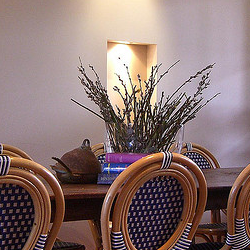

In [0]:
# center crop
crop(im)

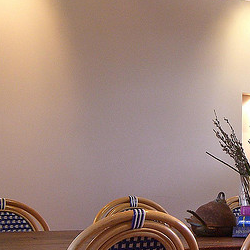

In [0]:
# random crop
rcrop(im)

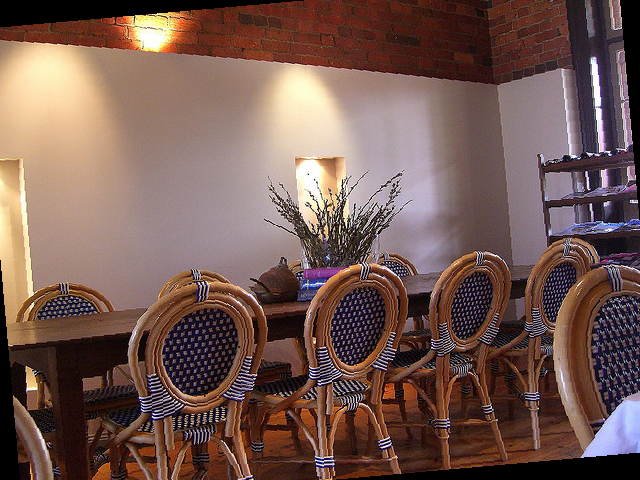

In [0]:
# random rotation: -20 to 20
rot(im)

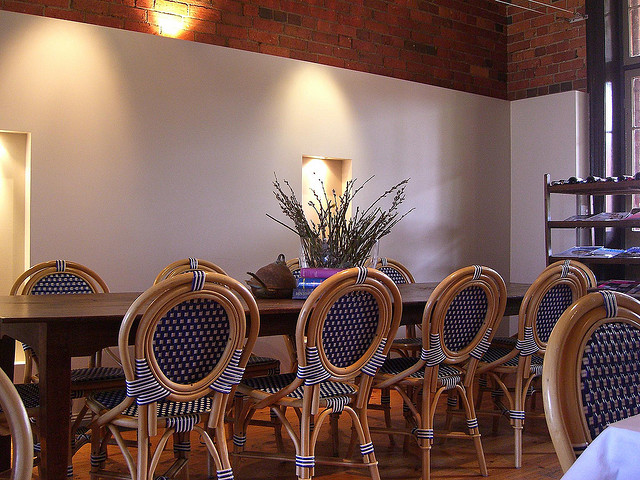

In [0]:
# flip with a probability of 50%
flip(im)

In [0]:
import glob

In [0]:
trn_files = glob.glob('coco/train2014/*')
val_files = glob.glob('coco/val2014/*')
len(trn_files), len(val_files)

(82783, 40504)

In [0]:
for file in trn_files:
    im = Image.open(file)
    im = crop(im)
    im.save(file)

In [0]:
for file in val_files:
    im = Image.open(file)
    im = crop(im)
    im.save(file)

In [0]:
trn_files[0]

'coco/train2014/COCO_train2014_000000095410.jpg'

## Building a vocabulary

In [0]:
import pickle

In [0]:
my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(x)]

In [0]:
x = my_tok.tokenizer("This is a random sentence")
for tok in x:
    print(tok.text)

This
is
a
random
sentence


In [0]:
coco = COCO(train_ann)
annIds = list(coco.anns.keys())
caption = coco.anns[annIds[0]]['caption']
spacy_tok(caption.lower())

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


['a', 'very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom']

In [0]:
def create_vocab(min_count = 2):
    counts = Counter()
    for cap_id in annIds:
        caption = coco.anns[cap_id]['caption']
        counts.update(spacy_tok(caption.lower()))
    print(f"Found a vocabulary of length {len(list(counts))}")

    for word in list(counts):
        if counts[word] < 5:
            # print(f"Deleting word {word}")
            del counts[word]
    print(f"Removed words with count less than 5. Final length {len(list(counts))}")
    return counts

In [0]:
counts = create_vocab()

Found a vocabulary of length 23474
Removed words with count less than 5. Final length 8787


In [0]:
# stores a mapping from words in our vocab to their respective indexes
vocab2index = {"":0, "UNK":1, "<start>":2, "<end>": 3}
words = ["", "UNK", "<start>", "<end>"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [0]:
with open(path/'vocab2index.pickle', 'wb') as handle:
    pickle.dump(vocab2index, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Encode sequences

In [0]:
def encode_sentence(caption, vocab2index):
    x = spacy_tok(str(caption).lower())
    x = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in x])
    x = np.concatenate(([vocab2index["<start>"]], x, [ vocab2index["<end>"]]))
    return x

In [0]:
cap_id = annIds[0]
caption = coco.anns[cap_id]['caption']
print(caption)
encode_sentence(caption, vocab2index)

A very clean and well decorated empty bathroom


array([ 2,  4,  5,  6,  7,  8,  9, 10, 11,  3])

In [0]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
# import cv2

imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

def normalize(im, stats=imagenet_stats):
    """Normalizes images with Imagenet stats."""
    # stats = stats[...,np.newaxis, np.newaxis]
    # print(stats.shape)
    # temp = (im - stats[0])
    return (im - stats[0])/stats[1]

def get_caption(coco, vocab, ann_id):
    caption = coco.anns[ann_id]['caption']
    return encode_sentence(caption, vocab)

class CocoDataset(Dataset):
    def __init__(self, path, json, vocab, transform = True, sz=250):
        self.path = path
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
        self.pipeline = tt.Compose([resize, rcrop, rot, flip])
        self.sz = sz
        self.captions = [get_caption(self.coco, vocab, ann_id) for ann_id in self.ids]
        
    def __getitem__(self, index):
        ann_id = self.ids[index]
        img_id = self.coco.anns[ann_id]['image_id']
        filename = self.coco.loadImgs(img_id)[0]['file_name']
        x = Image.open(self.path/filename)

        # convert the PIL Image to a tensor
        # this also changes the range to [0,1]
        
        if self.transform:
            x = self.pipeline(x)
        x = tt.ToTensor()(x).reshape(250,250,3)
        # print(x.shape)
        x = normalize(x)
        # print(x.shape)
        x = x.reshape(3,250,250)
        return x, self.captions[index]
        
    def __len__(self):
        return len(self.ids)

In [0]:
with open(path/'vocab2index.pickle', 'rb') as handle:
    vocab = pickle.load(handle)

In [0]:
len(vocab.keys())

8791

In [0]:
train_ds = CocoDataset(path/"train2014", path/"annotations/captions_train2014.json", vocab)
valid_ds = CocoDataset(path/"val2014", path/"annotations/captions_val2014.json", vocab, transform = False)

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [0]:
x, y = valid_ds[20]
x.shape, y

(torch.Size([3, 250, 250]),
 array([   2,    4,   11,   60,    7, 1058,  641, 1694,  745,   19,    3]))

In [0]:
print(len(train_ds), len(valid_ds)) # 40k valid images

414113 202654


In [0]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    Custom collate_fn for variable length padding. 
    Args:
        data: list of tuple (image, caption). 
            - image: numpy array of shape (3, 250, 250).
            - caption: list of word indexes of variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    # print(data)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = torch.Tensor(cap[:end])        
    return images, targets, lengths

In [0]:
trn_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(valid_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [0]:
# next(iter(trn_dl))

In [0]:
from torchvision.models import resnet18

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained a resnet model and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, x):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            x = self.resnet(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.bn(self.linear(x))
        return x

In [0]:
images, captions, lengths = next(iter(trn_dl))

In [0]:
images.shape

torch.Size([2, 3, 250, 250])

In [0]:
embed_size = 100
encoder_model = EncoderCNN(embed_size).cuda()

In [0]:
encoder_model(images.type(torch.FloatTensor).cuda()).shape

torch.Size([2, 100])

In [0]:
vocab_size = len(vocab.keys())

In [0]:
embed_size = 100
hidden_size = 50
embed = nn.Embedding(vocab_size, embed_size)
gru = nn.GRU(embed_size, hidden_size, 1, batch_first = True)
linear = nn.Linear(hidden_size, vocab_size)

In [0]:
images, captions, lengths = next(iter(trn_dl))

In [0]:
embeddings = embed(captions.long())

In [0]:
embeddings.shape

torch.Size([2, 13, 100])

In [0]:
features = encoder_model(images.type(torch.FloatTensor).cuda())
features.unsqueeze(1).shape

torch.Size([2, 1, 100])

In [0]:
train(trn_dl, num_epochs=10)